In [1]:
import glob
import os
import json
import pickle
import yaml

import math
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import utils
plt.rcParams.update({"font.size": 20})

/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
! ls ../Feb22_2017

DYJetsToLL_Pt-100To250                  TTToHadronic
DYJetsToLL_Pt-250To400                  TTToSemiLeptonic
DYJetsToLL_Pt-400To650                  VBFHToTauTau
DYJetsToLL_Pt-50To100                   VBFHToWWToLNuQQ_M-125_withDipoleRecoil
DYJetsToLL_Pt-650ToInf                  WJetsToLNu_HT-100To200
GluGluHToTauTau                         WJetsToLNu_HT-1200To2500
GluGluHToWWToLNuQQ                      WJetsToLNu_HT-200To400
GluGluHToWW_Pt-200ToInf_M-125           WJetsToLNu_HT-2500ToInf
HWminusJ_HToWW_M-125                    WJetsToLNu_HT-400To600
HWplusJ_HToWW_M-125                     WJetsToLNu_HT-600To800
HZJ_HToWW_M-125                         WJetsToLNu_HT-70To100

QCD_Pt_1400to1800                       WJetsToQQ_HT-200to400
QCD_Pt_170to300                         WJetsToQQ_HT-400to600
QCD_Pt_1800to2400                       WJetsToQQ_HT-600to800
QCD_Pt_2400to3200                       WJetsToQQ_HT-800toInf
QCD_Pt_300to470                         WW
QCD_Pt_3200toInf       

In [3]:
combine_samples = {
    # data
    "SingleElectron_": "SingleElectron",    
    "SingleMuon_": "SingleMuon",  
    "EGamma_": "EGamma",    
    
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "HWW",    
    "HToWW_M-125": "VH",
    "VBFHToWWToLNuQQ_M-125_withDipoleRecoil": "VBF",
    "ttHToNonbb_M125": "ttHToNonbb_M125",
    
    # bkg
    "QCD_Pt": "QCD",
    "DYJets": "DYJets",    
    "WJetsToLNu_": "WJetsLNu",
    "JetsToQQ": "WZQQ",
    "TT": "TTbar",
    "ST_": "SingleTop",
    "WW": "Diboson",
    "WZ": "Diboson",
    "ZZ": "Diboson",
}

In [4]:
weights = {
    "mu": {
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_isolation_muon": 1,
        "weight_id_muon": 1,
        "weight_vjets_nominal": 1,
    },
    "ele":{
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_electron": 1,
        "weight_reco_electron": 1,
        "weight_id_electron": 1,
        "weight_vjets_nominal": 1,   
    }
}

signals = [
        "HWW",        
        "ttHToNonbb_M125",
        "VH",
        "VBF"]

data_by_ch = {
    "ele": "SingleElectron",
    "mu": "SingleMuon",
}

nice_channel = {
    "mu": "Muon",
    "ele": "Electron"
}

In [5]:
def disc_score(df, sigs, bkgs):
    num = df[sigs].sum(axis=1) 
    den = df[sigs].sum(axis=1) + df[bkgs].sum(axis=1)
    return num/den

In [6]:
# scores definition
hwwev = ["fj_PN_probHWqqWev0c","fj_PN_probHWqqWev1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtauev1c"]
hwwmv = ["fj_PN_probHWqqWmv0c","fj_PN_probHWqqWmv1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtaumv1c"]
qcd = ["fj_PN_probQCDbb","fj_PN_probQCDcc","fj_PN_probQCDb","fj_PN_probQCDc","fj_PN_probQCDothers"]

tope = ["fj_PN_probTopbWev","fj_PN_probTopbWtauev"]
topm = ["fj_PN_probTopbWmv","fj_PN_probTopbWtaumv"]
tophad = ["fj_PN_probTopbWqq0c","fj_PN_probTopbWqq1c","fj_PN_probTopbWq0c","fj_PN_probTopbWq1c","fj_PN_probTopbWtauhv"]

top = tope+topm+tophad

# s/b

In [107]:
selections = {
    "mu": {
        ### pre-selection must include lepton isolation
        "pre-selection": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
        ### add mini-isolation for muons
        "mini-isolation": "( (lep_pt < 55) |  ( (lep_misolation < 0.2) & (lep_pt >= 55) ) )",
        
        ### checks
        "bjet_ophem": "( (fj_bjets_ophem < 0.3040) )",         
    },
    "ele": {
        ### pre-selection must include lepton isolation
        "pre-selection": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",    
        
        ### checks
        "bjet_ophem": "( (fj_bjets_ophem < 0.3040) )",        
    }    
}

In [108]:
samples_dir = "../Feb22_2017"
samples = os.listdir(samples_dir)

channels = ["mu", "ele"]

sigs = {
    "ele": hwwev,
    "mu": hwwmv,
}

qcd_bkg = [b.replace("PN","ParT") for b in qcd]
top_bkg = [b.replace("PN","ParT") for b in tope+topm+tophad]
inclusive_bkg = [b.replace("PN","ParT") for b in qcd+tope+topm+tophad]

events_dict = {}
for ch in channels:
    events_dict[ch] = {}

    new_sig = [s.replace("PN","ParT") for s in sigs[ch]]

    # get lumi
    with open("../fileset/luminosity.json") as f:
        luminosity = json.load(f)[ch]["2017"]

    for sample in samples:

        ### get a combined label to combine samples of the same process
        for key in combine_samples:
            if key in sample:
                sample_to_use = combine_samples[key]
                break
            else:
                sample_to_use = sample

        print(f"Finding {sample} samples and should combine them under {sample_to_use}")

        out_files = f"{samples_dir}/{sample}/outfiles/"
        parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
        pkl_files = glob.glob(f"{out_files}/*.pkl")

        if not parquet_files:
            print(f"No parquet file for {sample}")
            continue                

        data = pd.read_parquet(parquet_files)
        empty = len(data) == 0
        if empty:
            continue

        # get event_weight
    #     print(f"---> Retrieving event weight.")                
        event_weight = utils.get_xsecweight(pkl_files, "2017", sample, False, luminosity)
        for w in weights[ch]:
            if w not in data.keys():
    #             print(f"{w} weight is not stored in parquet")
                continue
            event_weight *= data[w]

        data["event_weight"] = event_weight
        
        # add QCD score 
        data["QCD"] = disc_score(data,new_sig,qcd_bkg)
        # add TOP score 
        data["Top"] = disc_score(data,new_sig,top_bkg)    
        # add inclusive score
        data["inclusive"] = disc_score(data,new_sig,inclusive_bkg)
            
        print(f"---> We have {len(data)} events.")        

        # apply selection
        for selection in selections[ch]:
            data = data.query(selections[ch][selection]) 
            print(f"---> Applied {selection}... Only {len(data)} events survived.")                    
 
            ### specify columns to keep
            columns_ = ["event_weight"]
            columns_ += ["fj_ParT_mass", "lep_fj_m"]  # to restrict s/b to a mass window
            columns_ += ["lep_met_mt"]  # for mT cuts
            columns_ += ["inclusive"]   # inclusive tagger score to cross check  
            columns_ += ["fj_pt"]  # cz why not

            # fill the big dataframe
            if sample_to_use not in events_dict[ch]:
                events_dict[ch][sample_to_use] = data[columns_]
            else:
                events_dict[ch][sample_to_use] = pd.concat([events_dict[ch][sample_to_use], data[columns_]])

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> We have 964 events.
---> Applied pre-selection... Only 949 events survived.
---> Applied mini-isolation... Only 938 events survived.
---> Applied bjet_ophem... Only 720 events survived.
Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> We have 9908 events.
---> Applied pre-selection... Only 9814 events survived.
---> Applied mini-isolation... Only 9694 events survived.
---> Applied bjet_ophem... Only 8590 events survived.
Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
---> We have 1177 events.
---> Applied pre-selection... Only 1150 events survived.
---> Applied mini-isolation... Only 1097 events survived.
---> Applied bjet_ophem... Only 1033 events survived.
Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
---> We have 12206 events.
---> Applied pre-selection... Only 11797 events survived.
---> Applied mini-iso

---> We have 42758 events.
---> Applied pre-selection... Only 35688 events survived.
---> Applied mini-isolation... Only 2873 events survived.
---> Applied bjet_ophem... Only 1030 events survived.
Finding QCD_Pt_1000to1400 samples and should combine them under QCD
---> We have 19732 events.
---> Applied pre-selection... Only 16884 events survived.
---> Applied mini-isolation... Only 917 events survived.
---> Applied bjet_ophem... Only 736 events survived.
Finding QCD_Pt_600to800 samples and should combine them under QCD
---> We have 14340 events.
---> Applied pre-selection... Only 12151 events survived.
---> Applied mini-isolation... Only 750 events survived.
---> Applied bjet_ophem... Only 639 events survived.
Finding QCD_Pt_300to470 samples and should combine them under QCD
---> We have 6434 events.
---> Applied pre-selection... Only 5213 events survived.
---> Applied mini-isolation... Only 421 events survived.
---> Applied bjet_ophem... Only 363 events survived.
Finding WJetsToQQ_HT

Finding QCD_Pt_3200toInf samples and should combine them under QCD
---> We have 180 events.
---> Applied pre-selection... Only 177 events survived.
---> Applied bjet_ophem... Only 146 events survived.
Finding HWplusJ_HToWW_M-125 samples and should combine them under VH
---> We have 9257 events.
---> Applied pre-selection... Only 9210 events survived.
---> Applied bjet_ophem... Only 8047 events survived.
Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
---> We have 86 events.
---> Applied pre-selection... Only 86 events survived.
---> Applied bjet_ophem... Only 41 events survived.
Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
---> We have 25645 events.
---> Applied pre-selection... Only 25542 events survived.
---> Applied bjet_ophem... Only 6818 events survived.
Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
---> We have 20379 events.
---> Applied pre-selection... Only 20233 events survived.
-

In [109]:
events_dict.keys()

dict_keys(['mu', 'ele'])

In [95]:
events_dict["mu"].keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Diboson', 'ttHToNonbb_M125'])

## Get cutflows and s/b

In [69]:
channels = ["mu"]

mT_cuts = [999999, 40, 50, 60, 70, 80, 90, 100]

cutflows = {}
for sample in events_dict["mu"]:
    cutflows[sample] = {}

s, b = {}, {}
for mT_cut in mT_cuts:
    if mT_cut==999999:
        cut_label = "pre-selection"
    else:
        cut_label = f"pre-selection + mT<{mT_cut:.2f}"

    s[cut_label], b[cut_label] = 0, 0

    for ch in channels:   # sum over channels
        for sample in events_dict[ch]:
            df = events_dict[ch][sample]
            
            keep = ( df["lep_met_mt"]<mT_cut )
            df = df.loc[keep, :]
            
            ### cutflows
            cutflows[sample][cut_label] = len(df)

            ### mass window
            regressed_mass = df["fj_ParT_mass"]     
            lep_fj_m = df["lep_fj_m"]     
    #         mass_window = (regressed_mass>100) & (regressed_mass<150)
            mass_window = (lep_fj_m>0) & (lep_fj_m<150)

            ### s/b
            ev_weight = df["event_weight"]        
            if sample in signals:
                s[cut_label] += ev_weight[mass_window].sum()
            else:
                b[cut_label] += ev_weight[mass_window].sum()    

In [70]:
for mT_cut in s:
    print(f"{mT_cut} : s/b = {s[mT_cut]/math.sqrt(b[mT_cut])}")

pre-selection : s/b = 0.6938032490309872
pre-selection + mT<40.00 : s/b = 0.4351586930995031
pre-selection + mT<50.00 : s/b = 0.48842102916501545
pre-selection + mT<60.00 : s/b = 0.5231426902071433
pre-selection + mT<70.00 : s/b = 0.5538607201840319
pre-selection + mT<80.00 : s/b = 0.5758888353990184
pre-selection + mT<90.00 : s/b = 0.6034930238094884
pre-selection + mT<100.00 : s/b = 0.6203571415201107


In [71]:
for sample in cutflows:
    if sample in ["HWW", "WJetsLNu", "QCD", "TTbar"]:        
        print(sample)    
        for mT_cut in cutflows[sample]:
            print(f"{mT_cut} : {cutflows[sample][mT_cut]}")
        print("---------------------------------")            

WJetsLNu
pre-selection : 2489135
pre-selection + mT<40.00 : 673277
pre-selection + mT<50.00 : 866845
pre-selection + mT<60.00 : 1074455
pre-selection + mT<70.00 : 1293436
pre-selection + mT<80.00 : 1510977
pre-selection + mT<90.00 : 1706751
pre-selection + mT<100.00 : 1868985
---------------------------------
TTbar
pre-selection : 3258618
pre-selection + mT<40.00 : 683497
pre-selection + mT<50.00 : 876349
pre-selection + mT<60.00 : 1080351
pre-selection + mT<70.00 : 1294146
pre-selection + mT<80.00 : 1509191
pre-selection + mT<90.00 : 1716426
pre-selection + mT<100.00 : 1905882
---------------------------------
HWW
pre-selection : 40650
pre-selection + mT<40.00 : 15952
pre-selection + mT<50.00 : 19614
pre-selection + mT<60.00 : 23133
pre-selection + mT<70.00 : 26241
pre-selection + mT<80.00 : 28999
pre-selection + mT<90.00 : 31526
pre-selection + mT<100.00 : 33539
---------------------------------
QCD
pre-selection : 87402
pre-selection + mT<40.00 : 46259
pre-selection + mT<50.00 : 525

In [72]:
## OTHERS
print("Counting events of the following samples:")
c = [0] * len(cutflows[sample])
for sample in cutflows:
    if sample not in ["HWW", "QCD", "TTbar", "WJetsLNu"]:
        if sample not in signals:
            print(sample)
            for i, mT_cut in enumerate(cutflows[sample]):
                c[i] += cutflows[sample][mT_cut]
print("---------------------------------")  
for i, mT_cut in enumerate(cutflows[sample]):
    print(f"{mT_cut}: {c[i]}")

Counting events of the following samples:
DYJets
SingleTop
WZQQ
Diboson
---------------------------------
pre-selection: 1165241
pre-selection + mT<40.00: 383070
pre-selection + mT<50.00: 465756
pre-selection + mT<60.00: 545915
pre-selection + mT<70.00: 625793
pre-selection + mT<80.00: 703262
pre-selection + mT<90.00: 774366
pre-selection + mT<100.00: 837867


# s/b as a function of the tagger cut

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


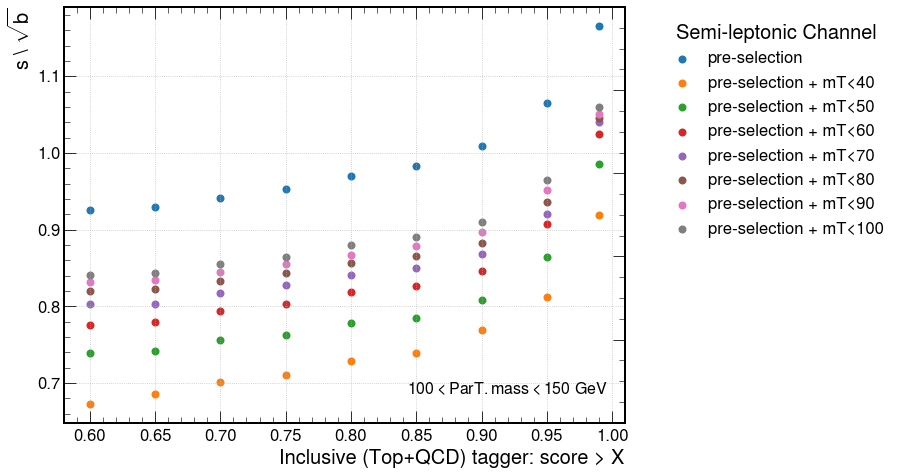

In [73]:
plt.rcParams.update({"font.size": 20})
channels = ["mu", "ele"]

fig, ax = plt.subplots(figsize=(13,7))
ax.grid()    

mT_cuts = [999999, 40, 50, 60, 70, 80, 90, 100]
for mT_cut in mT_cuts:
    if mT_cut==999999:
        cut_label = "pre-selection"
    else:
        cut_label = f"pre-selection + mT<{mT_cut}"

    tagger_cuts = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

    s = [0]*len(tagger_cuts)
    b = [0]*len(tagger_cuts)

    for ch in channels:
        for sample in events_dict[ch]:
            
            df = events_dict[ch][sample]
            ### apply mT cut
            keep = ( df["lep_met_mt"]<mT_cut )
            df = df.loc[keep, :]
                        
            ev_weight = df["event_weight"]
            score = df["inclusive"]

            regressed_mass = df["fj_ParT_mass"]
            mass_window = (regressed_mass>100) & (regressed_mass<150)

            for i, tagger_cut in enumerate(tagger_cuts):
                score_cut = (score > tagger_cut)
                if sample in signals:
                    s[i] += ev_weight[mass_window & score_cut].sum()     
                else:
                    b[i] += ev_weight[mass_window & score_cut].sum()

    ss = np.array(s)
    bb = np.array(b)
    ax.scatter(tagger_cuts, ss/np.sqrt(bb) , linewidth=2.0, label=cut_label)

ax.set_xlabel("Inclusive (Top+QCD) tagger: score > X")
ax.set_ylabel(r"s \ $\sqrt{b}$")
if len(channels)==2:
    ax.legend(title="Semi-leptonic Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);
else:
    ax.legend(title=f"{nice_channel[ch]} Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);

ax2 = ax.twinx()
ax2.set_yticklabels([])
ax2.legend(title=r"$100<ParT.mass<150$ GeV", title_fontsize=16, loc=4)
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


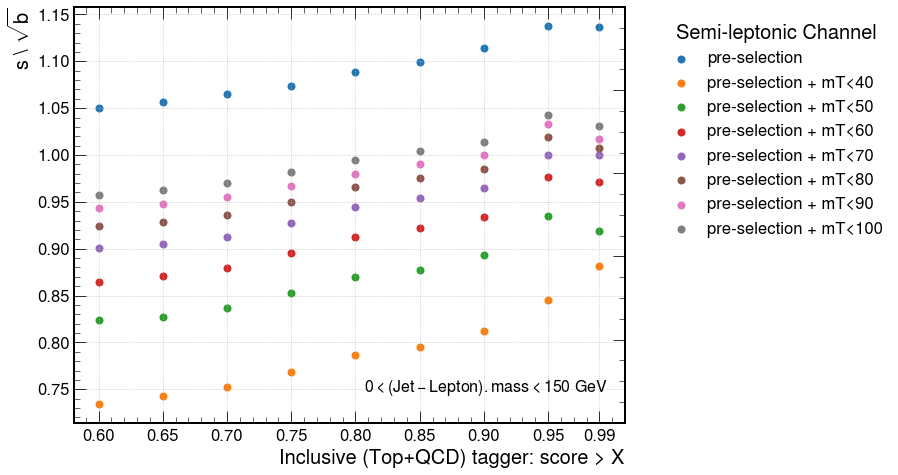

In [74]:
plt.rcParams.update({"font.size": 20})
channels = ["mu", "ele"]

fig, ax = plt.subplots(figsize=(13,7))
ax.grid()    

mT_cuts = [999999, 40, 50, 60, 70, 80, 90, 100]
for mT_cut in mT_cuts:
    if mT_cut==999999:
        cut_label = "pre-selection"
    else:
        cut_label = f"pre-selection + mT<{mT_cut}"
  
    tagger_cuts = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

    s = [0]*len(tagger_cuts)
    b = [0]*len(tagger_cuts)

    for ch in channels:
        for sample in events_dict[ch]:
            
            df = events_dict[ch][sample]
            ### apply mT cut
            keep = ( df["lep_met_mt"]<mT_cut )
            df = df.loc[keep, :]
                        
            ev_weight = df["event_weight"]
            score = df["inclusive"]

            lep_fj_m = df["lep_fj_m"]
            mass_window = (lep_fj_m>0) & (lep_fj_m<150)

            for i, tagger_cut in enumerate(tagger_cuts):
                score_cut = (score > tagger_cut)
                if sample in signals:
                    s[i] += ev_weight[mass_window & score_cut].sum()     
                else:
                    b[i] += ev_weight[mass_window & score_cut].sum()

    ss = np.array(s)
    bb = np.array(b)
    ax.scatter(tagger_cuts, ss/np.sqrt(bb) , linewidth=2.0, label=cut_label)

ax.set_xticks(tagger_cuts)
ax.set_xlabel("Inclusive (Top+QCD) tagger: score > X")
ax.set_ylabel(r"s \ $\sqrt{b}$")
if len(channels)==2:
    ax.legend(title="Semi-leptonic Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);
else:
    ax.legend(title=f"{nice_channel[ch]} Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);

ax2 = ax.twinx()
ax2.set_yticklabels([])
ax2.legend(title=r"$0<(Jet-Lepton).mass<150$ GeV", title_fontsize=16, loc=4)
plt.tight_layout()

# Stacked plots

In [96]:
# plot histograms
color_by_sample = {
    "HWW": "coral",
    "ttHToNonbb_M125": "tab:olive",
    "VH": "tab:brown",
    "VBF": "tab:gray",

    "DYJets": "tab:purple",
    "QCD": "tab:orange",
    "Diboson": "orchid",    
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "WZQQ": "salmon",
    "SingleTop": "tab:cyan",
    
    "WplusHToTauTau": "tab:cyan",
    "WminusHToTauTau": "tab:cyan",
    "ttHToTauTau": "tab:cyan",
    "GluGluHToTauTau": "tab:cyan",
    "ZHToTauTau": "tab:cyan",
    "VBFHToTauTau": "tab:cyan",
}

plot_labels = {
    "HWW": "ggH(WW)-Pt200",    
    "ttHToNonbb_M125": "ttH(WW)",
    "VH": "VH(WW)",
    "VBF": r"VBFH(WW) $(qq\ell\nu)$",
    
    "DYJets": r"Z$(\ell\ell)$+jets",    
    "QCD": "Multijet",
    "Diboson": "VV",
    "WJetsLNu": r"W$(\ell\nu)$+jets",
    "TTbar": r"$t\bar{t}$+jets",
    "WZQQ": r"W/Z$(qq)$",
    "SingleTop": r"Single Top",
    
    "WplusHToTauTau": "WplusHToTauTau",
    "WminusHToTauTau": "WminusHToTauTau",
    "ttHToTauTau": "ttHToTauTau",
    "GluGluHToTauTau": "GluGluHToTauTau",
    "ZHToTauTau": "ZHToTauTau",
    "VBFHToTauTau": "VBFHToTauTau"
}

label_by_ch = {
    "mu": "Muon",    
    "ele": "Electron",
}

signals = [
        "HWW",        
        "ttHToNonbb_M125",
        "VH",
        "VBF"]

In [97]:
def plot_hists(hists, vars_to_plot, logy, title_):
    vars_to_plot = ["lep_fj_m"]

    add_data = False
    add_soverb = True
    only_sig = False

    # luminosity
    luminosity = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum = json.load(f)[ch]["2017"]
            luminosity += lum / 1000.0
    luminosity = luminosity/2

    for var in vars_to_plot:
        if var not in hists.keys():
            print(f"{var} not stored in hists")
            continue

        print(f"Will plot {var} histogram")

        # get histograms
        h = hists[var]

        if (h.shape[0] == 0):  # skip empty histograms (such as lepton_pt for hadronic channel)
            print("Empty histogram ", var)
            continue

        # get samples existing in histogram
        samples = [h.axes[0].value(i) for i in range(len(h.axes[0].edges))]
        signal_labels = [label for label in samples if label in signals]
        bkg_labels = [
            label
            for label in samples
            if (label and label not in signal_labels)
        ]

        # get total yield of backgrounds per label
        # (sort by yield in fixed fj_pt histogram after pre-sel)        
        order_dic = {}
        for bkg_label in bkg_labels:
            if "fj_pt" in hists.keys():
                order_dic[plot_labels[bkg_label]] = hists["fj_pt"][{"samples": bkg_label}].sum()
            else:
                order_dic[plot_labels[bkg_label]] = hists[var][{"samples": bkg_label}].sum()

        # data
        data = None

        # signal
        signal = [h[{"samples": label}] for label in signal_labels]
        # scale signal for non-log plots
        if logy:
            mult_factor = 1
        else:
            mult_factor = 100
        signal_mult = [s * mult_factor for s in signal]

        # background
        bkg = [h[{"samples": label}] for label in bkg_labels]

        if add_data and data and len(bkg) > 0:
            if add_soverb and len(signal) > 0:
                fig, (ax, rax, sax) = plt.subplots(
                    nrows=3,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1, 1), "hspace": 0.07},
                    sharex=True,
                )
            else:
                fig, (ax, rax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                sax = None
        else:
            if add_soverb and len(signal) > 0:
                fig, (ax, sax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                rax = None
            else:
    #                 fig, ax = plt.subplots(1, 1)
                fig, ax = plt.subplots(figsize=(8,8))                
                rax = None
                sax = None

        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
        }

        # sum all of the background
        if len(bkg) > 0:
            tot = bkg[0].copy()
            for i, b in enumerate(bkg):
                if i > 0:
                    tot = tot + b

            tot_val = tot.values()
            tot_val_zero_mask = tot_val == 0
            tot_val[tot_val_zero_mask] = 1

            tot_err = np.sqrt(tot_val)
            tot_err[tot_val_zero_mask] = 0

            # print(f'Background yield: ',tot_val,np.sum(tot_val))

        if add_data and data:
            data_err_opts = {
                "linestyle": "none",
                "marker": ".",
                "markersize": 10.0,
                "elinewidth": 1,
            }
            hep.histplot(
                data,
                ax=ax,
                histtype="errorbar",
                color="k",
                capsize=4,
                yerr=True,
                label=data_label,
                **data_err_opts,
            )

            if len(bkg) > 0:
                from hist.intervals import ratio_uncertainty

                data_val = data.values()
                data_val[tot_val_zero_mask] = 1

                yerr = ratio_uncertainty(data_val, tot_val, "poisson")

                hep.histplot(
                    data_val / tot_val,
                    tot.axes[0].edges,
                    # yerr=np.sqrt(data_val) / tot_val,
                    yerr=yerr,
                    ax=rax,
                    histtype="errorbar",
                    color="k",
                    capsize=4,
                )

                rax.axhline(1, ls="--", color="k")
                rax.set_ylim(0.2, 1.8)
                # rax.set_ylim(0.7, 1.3)

        # plot the background
        if len(bkg) > 0 and not only_sig:
            hep.histplot(
                bkg,
                ax=ax,
                stack=True,
                sort="yield",
                edgecolor="black",
                linewidth=1,
                histtype="fill",
                label=[plot_labels[bkg_label] for bkg_label in bkg_labels],
                color=[color_by_sample[bkg_label] for bkg_label in bkg_labels],
            )
            ax.stairs(
                values=tot.values() + tot_err,
                baseline=tot.values() - tot_err,
                edges=tot.axes[0].edges,
                **errps,
                label="Stat. unc.",
            )

        # plot the signal (times 10)
        if len(signal) > 0:
            tot_signal = None
            for i, sig in enumerate(signal_mult):
                lab_sig_mult = f"{mult_factor} * {plot_labels[signal_labels[i]]}"
                if mult_factor == 1:
                    lab_sig_mult = f"{plot_labels[signal_labels[i]]}"
                hep.histplot(
                    sig,
                    ax=ax,
                    label=lab_sig_mult,
                    linewidth=3,
                    color=color_by_sample[signal_labels[i]],
                )

                if tot_signal == None:
                    tot_signal = signal[i].copy()
                else:
                    tot_signal = tot_signal + signal[i]

            # plot the total signal (w/o scaling)
            hep.histplot(
                tot_signal, ax=ax, label=f"ggF+VBF+VH+ttH", linewidth=3, color="tab:red"
            )
            # add MC stat errors
            ax.stairs(
                values=tot_signal.values() + np.sqrt(tot_signal.values()),
                baseline=tot_signal.values() - np.sqrt(tot_signal.values()),
                edges=sig.axes[0].edges,
                **errps,
            )

            if sax is not None:
                totsignal_val = tot_signal.values()
                # replace values where bkg is 0
                totsignal_val[tot_val == 0] = 0
                soverb_val = totsignal_val / np.sqrt(tot_val)
                hep.histplot(
                    soverb_val,
                    tot_signal.axes[0].edges,
                    label="Total Signal",
                    ax=sax,
                    linewidth=3,
                    color="tab:red",
                )

                # integrate soverb in a given range for lep_fj_m (which, intentionally, is the first variable we pass)
                if var == "lep_fj_m":
                    bin_array = tot_signal.axes[0].edges[
                        :-1
                    ]  # remove last element since bins have one extra element
                    range_max = 150
                    range_min = 0

                    condition = (bin_array >= range_min) & (bin_array <= range_max)

                    s = totsignal_val[
                        condition
                    ].sum()  # sum/integrate signal counts in the range
                    b = np.sqrt(
                        tot_val[condition].sum()
                    )  # sum/integrate bkg counts in the range and take sqrt

                    soverb_integrated = round((s / b).item(), 2)
                    sax.legend(title=f"S/sqrt(B) (in 0-150)={soverb_integrated}")

        ax.set_ylabel("Events")
        if sax is not None:
            ax.set_xlabel("")
            if rax is not None:
                rax.set_xlabel("")
                rax.set_ylabel("Data/MC", fontsize=20)
            sax.set_ylabel(r"S/$\sqrt{B}$", fontsize=20)
    #             sax.set_xlabel(f"{utils.axis_dict[var].label}")
            sax.set_xlabel(f"{h.axes[-1].label}")   # assumes the variable to be plotted is at the last axis

        elif rax is not None:
            ax.set_xlabel("")
    #             rax.set_xlabel(f"{utils.axis_dict[var].label}")
            rax.set_xlabel(f"{h.axes[-1].label}")    # assumes the variable to be plotted is at the last axis

            rax.set_ylabel("Data/MC", fontsize=20)

        # get handles and labels of legend
        handles, labels = ax.get_legend_handles_labels()

        # append legend labels in order to a list
        summ = []
        for label in labels[: len(bkg_labels)]:
            summ.append(order_dic[label])
        # get indices of labels arranged by yield
        order = []
        for i in range(len(summ)):
            order.append(np.argmax(np.array(summ)))
            summ[np.argmax(np.array(summ))] = -100

        # plot data first, then bkg, then signal
        hand = [handles[-1]] + [handles[i] for i in order] + handles[len(bkg) : -1]
        lab = [labels[-1]] + [labels[i] for i in order] + labels[len(bkg) : -1]

        ax.legend(
            [hand[idx] for idx in range(len(hand))],
            [lab[idx] for idx in range(len(lab))],
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            title=f"Semi-Leptonic Channel",
        )

        if logy:
            ax.set_yscale("log")
            ax.set_ylim(1e-1)

            hep.cms.lumitext(
                "%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20
            )
        hep.cms.text("Work in Progress", ax=ax, fontsize=15)

        ax2 = ax.twinx()
        ax2.set_yticklabels([])
        ax2.legend(title=title_, title_fontsize=20, loc=1)

In [113]:
channels = ["mu", "ele"]
### get samples_to_plot
samples_to_plot = list(events_dict[ch])

mT_cut = 100

# fill histograms
hists = {}
for var in ["fj_pt", "lep_fj_m"]:#, "fj_ParT_mass"]:
    if var == "fj_ParT_mass":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Regular(30, 0, 260, name="var", label=r"fj_ParT_mass [GeV]", overflow=True)
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utils.axis_dict[var],
        )
        
    for sample in samples_to_plot:
        
        for ch in channels:
            
            df = events_dict[ch][sample]
            ### apply mT cut
            keep = ( df["lep_met_mt"]<mT_cut )
            df = df.loc[keep, :]
      
            ### apply tagger cut
            keep = ( df["inclusive"]>0.9 )
            df = df.loc[keep, :]
            
            hists[var].fill(
                samples=sample,
                var=df[var],                
                weight=df["event_weight"]
                
            )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Will plot lep_fj_m histogram


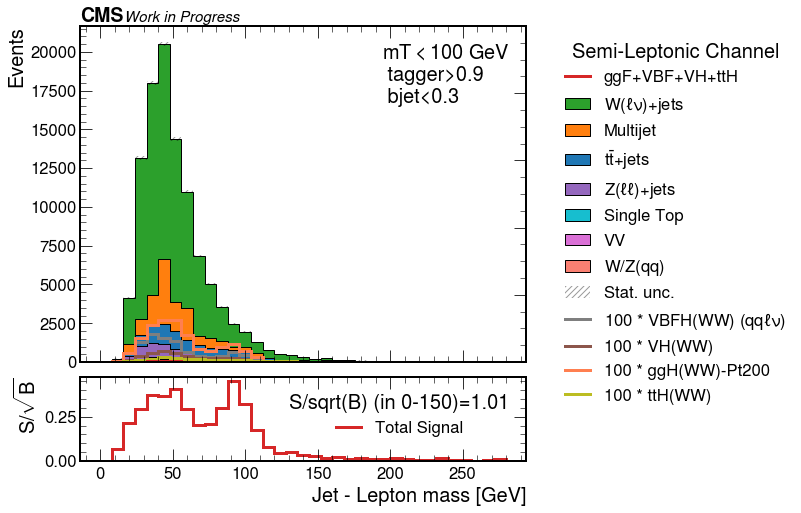

In [114]:
# plot_hists(hists, ["lep_fj_m"], False, rf"$mT>{mT_cut}$ GeV" + "\n bjet<0.3")
# plot_hists(hists, ["lep_fj_m"], False, rf"$mT>{mT_cut}$ GeV" + "\n tagger>0.9")
plot_hists(hists, ["lep_fj_m"], False, rf"$mT<{mT_cut}$ GeV" + "\n tagger>0.9" + "\n bjet<0.3")